In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
% pip install sentencepiece

     |████████████████████████████████| 1.0MB 2.7MB/s 


In [0]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [0]:
df_main = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTrain_raw.csv')
df_test = pd.read_csv('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/drugsComTest_raw.csv')

In [0]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (161297, 7)
Training Set Memory Usage = 8.61 MB
Test Set Shape = (53766, 7)
Test Set Memory Usage = 2.87 MB


In [0]:
# combining the two data sets
df_main = pd.concat([df_train, df_test], axis=0,ignore_index=True)

In [0]:
df_main.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [0]:
df_main = df_main.loc[(df_main['rating'] <= 3) | (df_main['rating'] == 10)]

df_main['rank']=df_main['rating'].apply(lambda x: 1 if x>=8 else 0)

df_main.drop(['uniqueID','rating','date', 'condition', 'drugName', 'usefulCount'],axis=1,inplace=True)
df_main.head()

KeyError: ignored

In [0]:
df_main.drop(['drugName'],axis=1,inplace=True)


In [0]:
df_main.head()

,review,rank
5,"""2nd day on 5mg started to work with rock hard...",0
6,"""He pulled out, but he cummed a bit in me. I t...",0
7,"""Abilify changed my life. There is hope. I was...",1
8,""" I Ve had nothing but problems with the Kepp...",0
11,"""I have taken anti-depressants for years, with...",1


In [0]:
df_main['rank']=df_main['text']

In [0]:
df_main['text']=df_main['review']
df_main.drop(['review'],axis=1,inplace=True)

In [0]:

df_main.head()


,rank,text
5,0,"""2nd day on 5mg started to work with rock hard..."
6,0,"""He pulled out, but he cummed a bit in me. I t..."
7,1,"""Abilify changed my life. There is hope. I was..."
8,0,""" I Ve had nothing but problems with the Kepp..."
11,1,"""I have taken anti-depressants for years, with..."


In [0]:
# word_count
df_main['word_count'] = df_main['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_main['unique_word_count'] = df_main['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_main['stop_word_count'] = df_main['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_main['url_count'] = df_main['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_main['mean_word_length'] = df_main['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_main['char_count'] = df_main['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_main['punctuation_count'] = df_main['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_main['hashtag_count'] = df_main['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_main['mention_count'] = df_main['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [0]:
df_main['target']=df_main['rank']

In [0]:
df_main.drop(['rank'],axis=1,inplace=True)

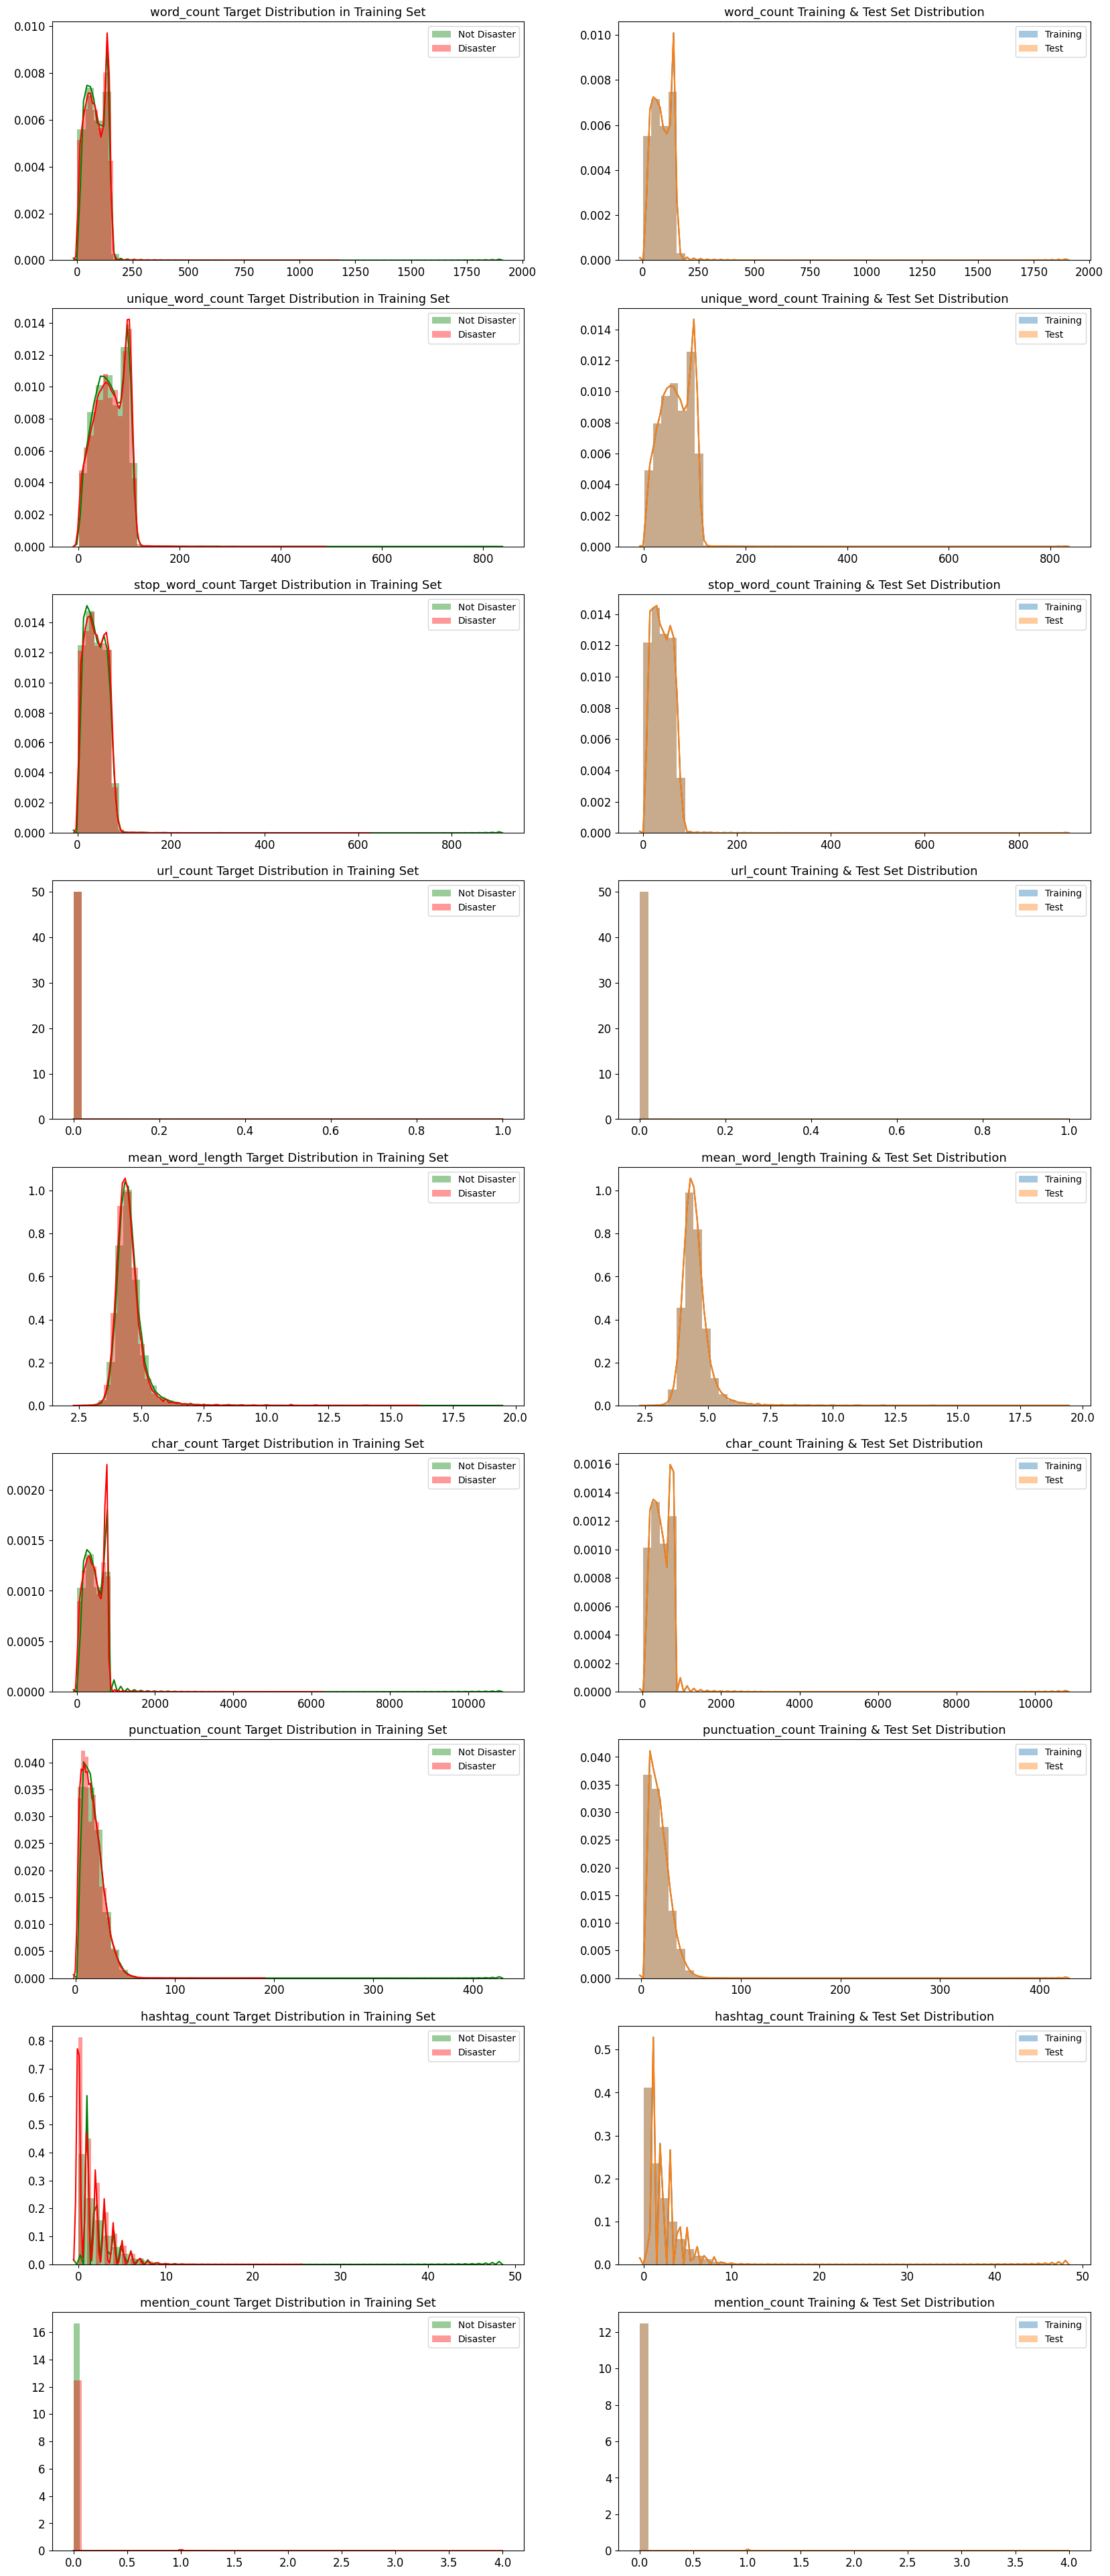

In [0]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_main['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_main.loc[~DISASTER_TWEETS][feature], label='Negative', ax=axes[i][0], color='green')
    sns.distplot(df_main.loc[DISASTER_TWEETS][feature], label='Positive', ax=axes[i][0], color='red')

    sns.distplot(df_main[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_main[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

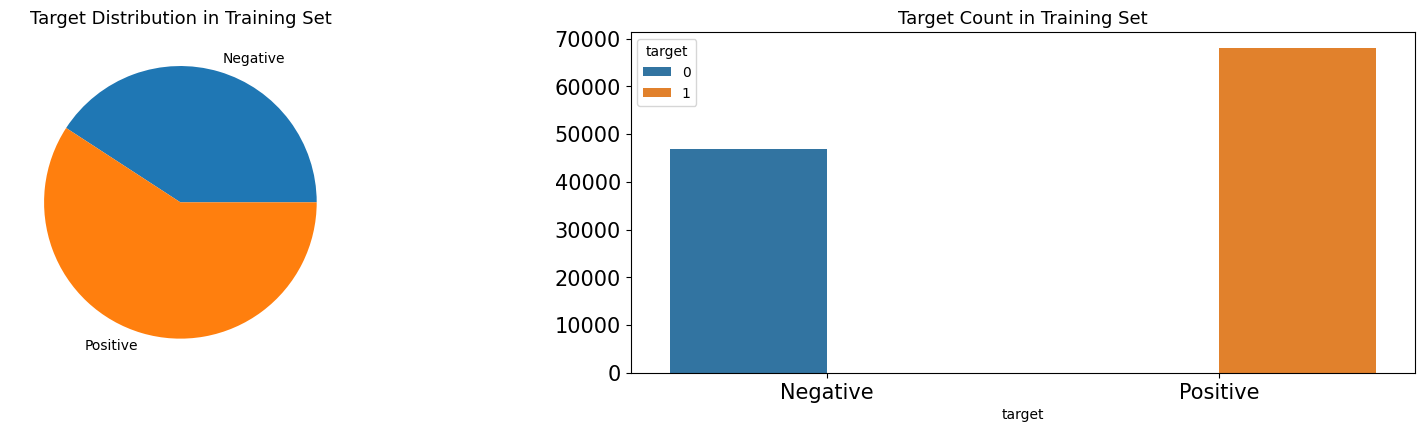

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_main.groupby('target').count()['text'].plot(kind='pie', ax=axes[0], labels=['Negative', 'Positive'])
sns.countplot(x=df_main['target'], hue=df_main['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Negative', 'Positive'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [0]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_main[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_main[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_main[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_main[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_main[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_main[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

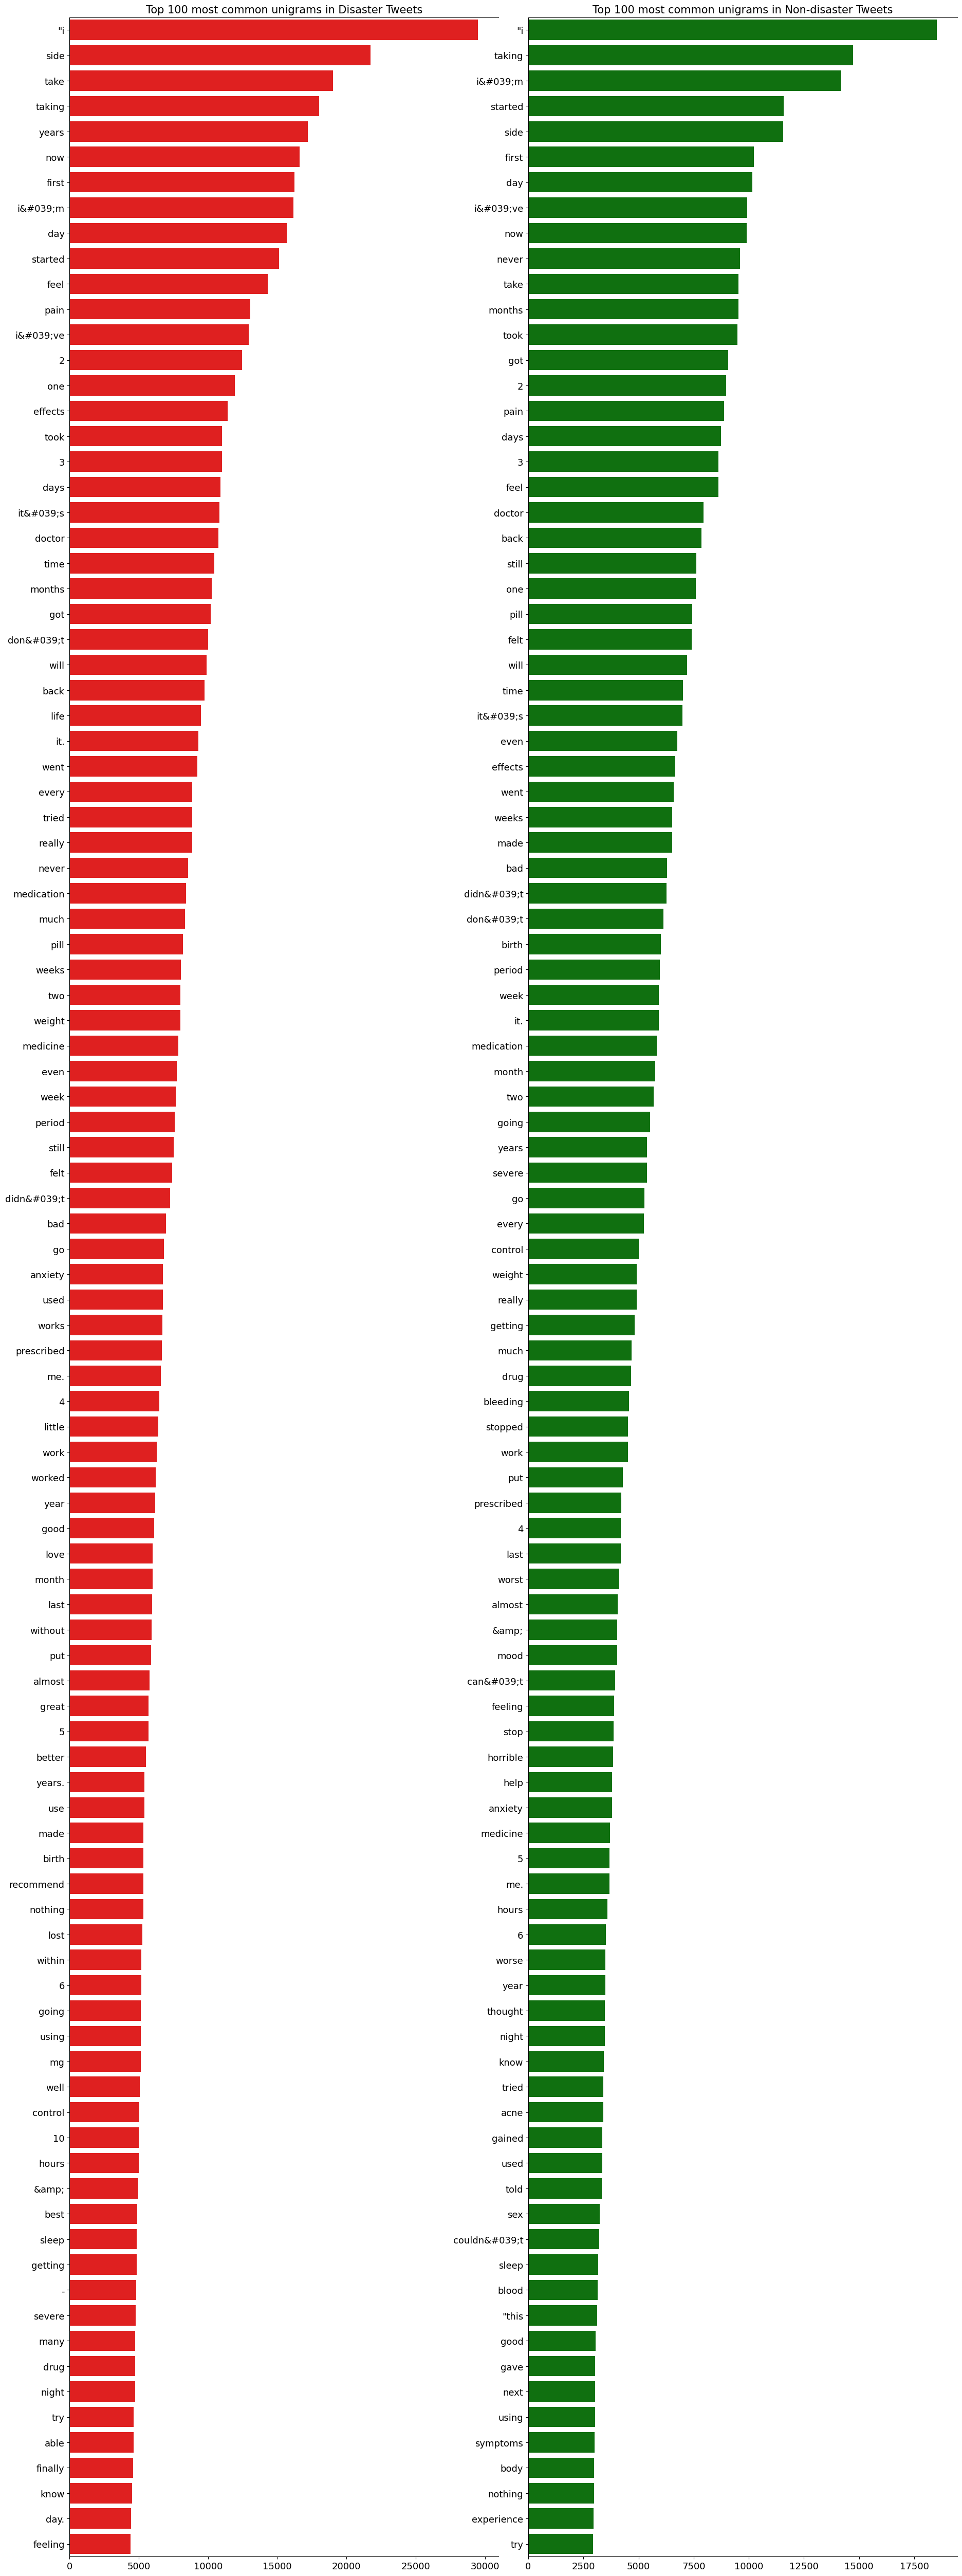

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

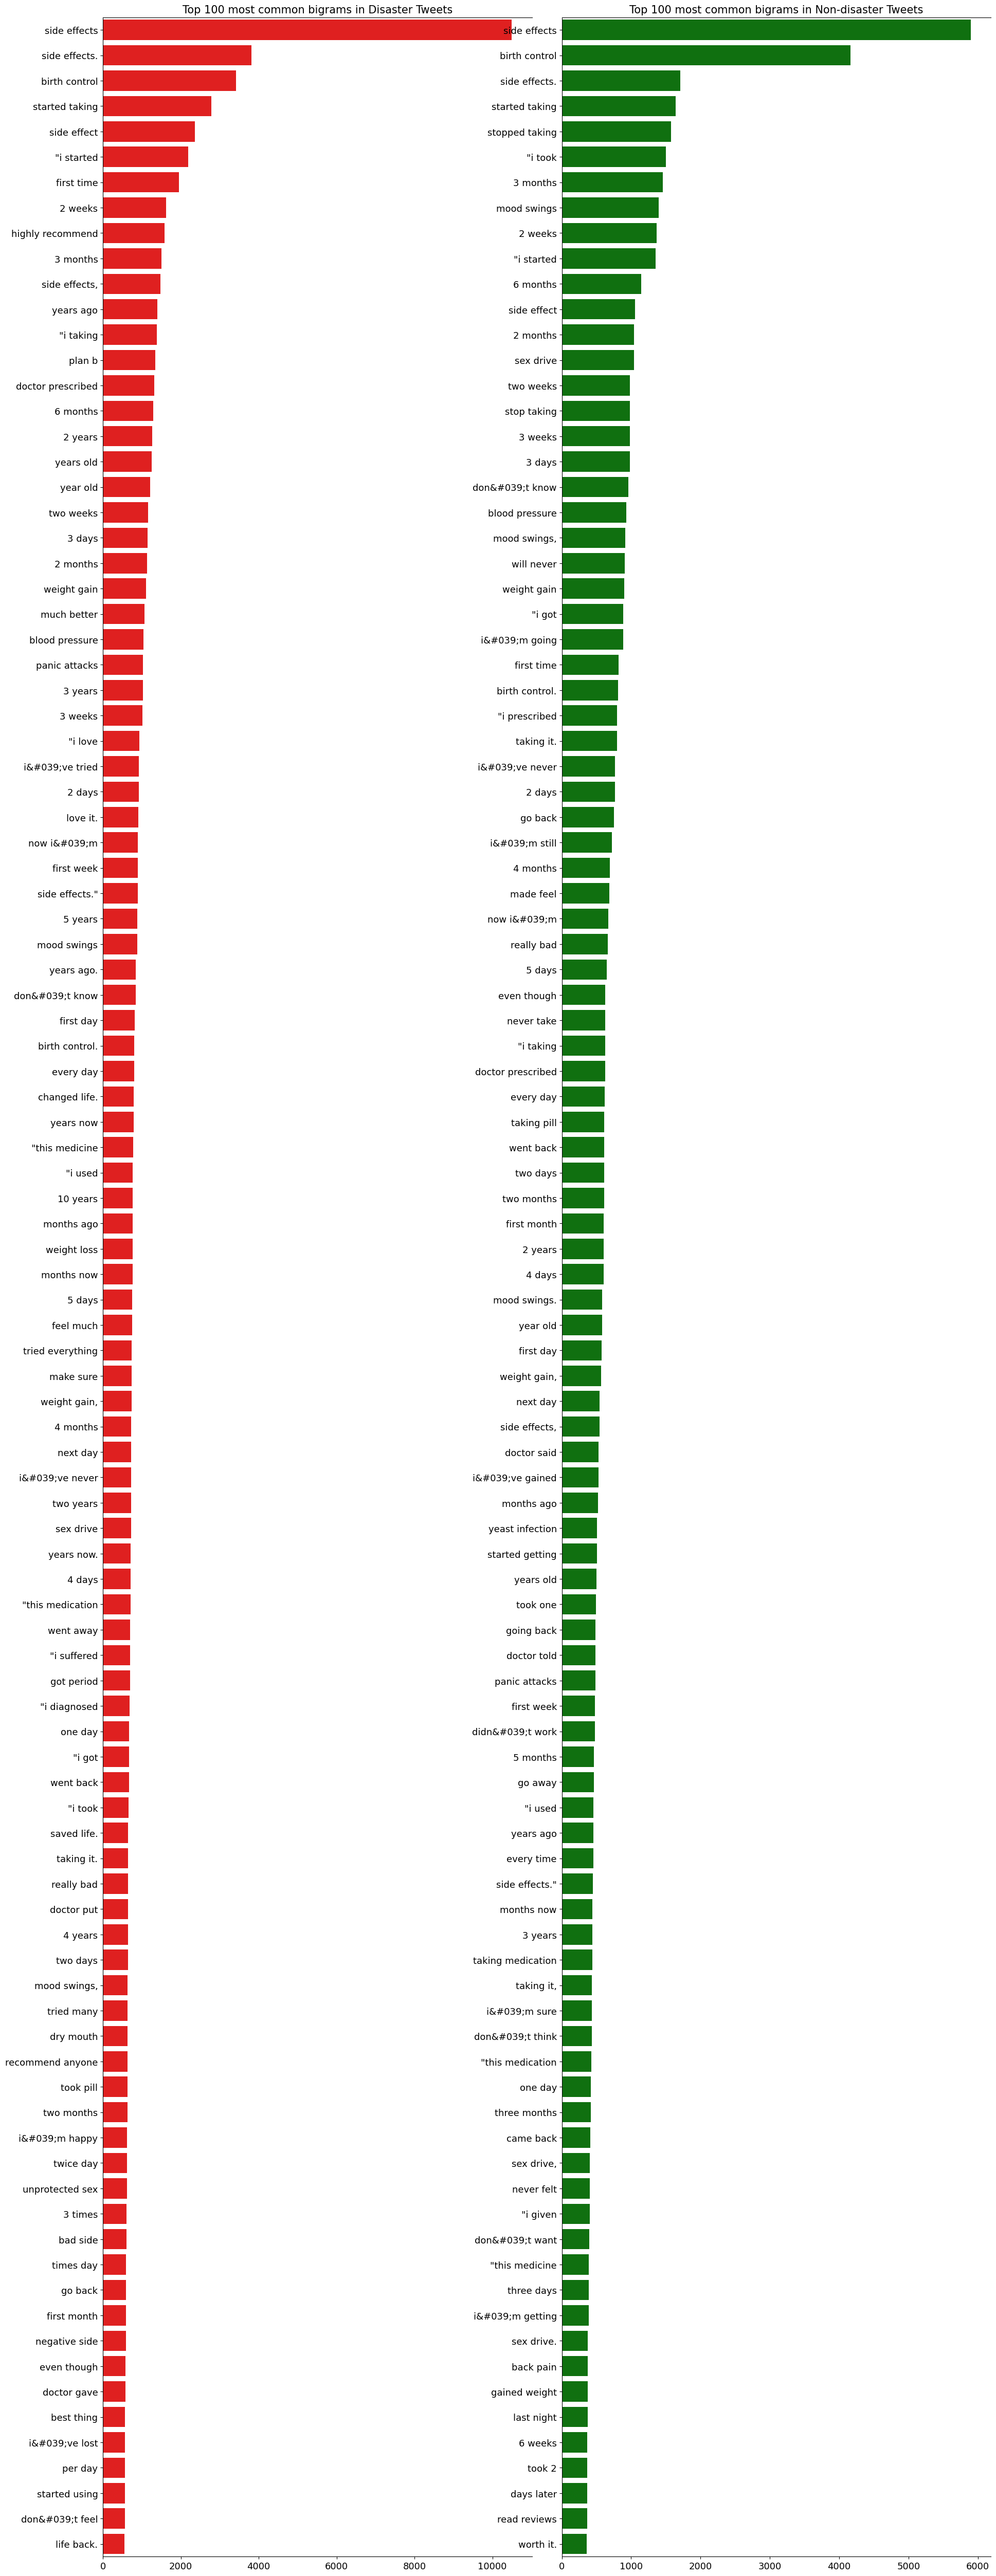

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

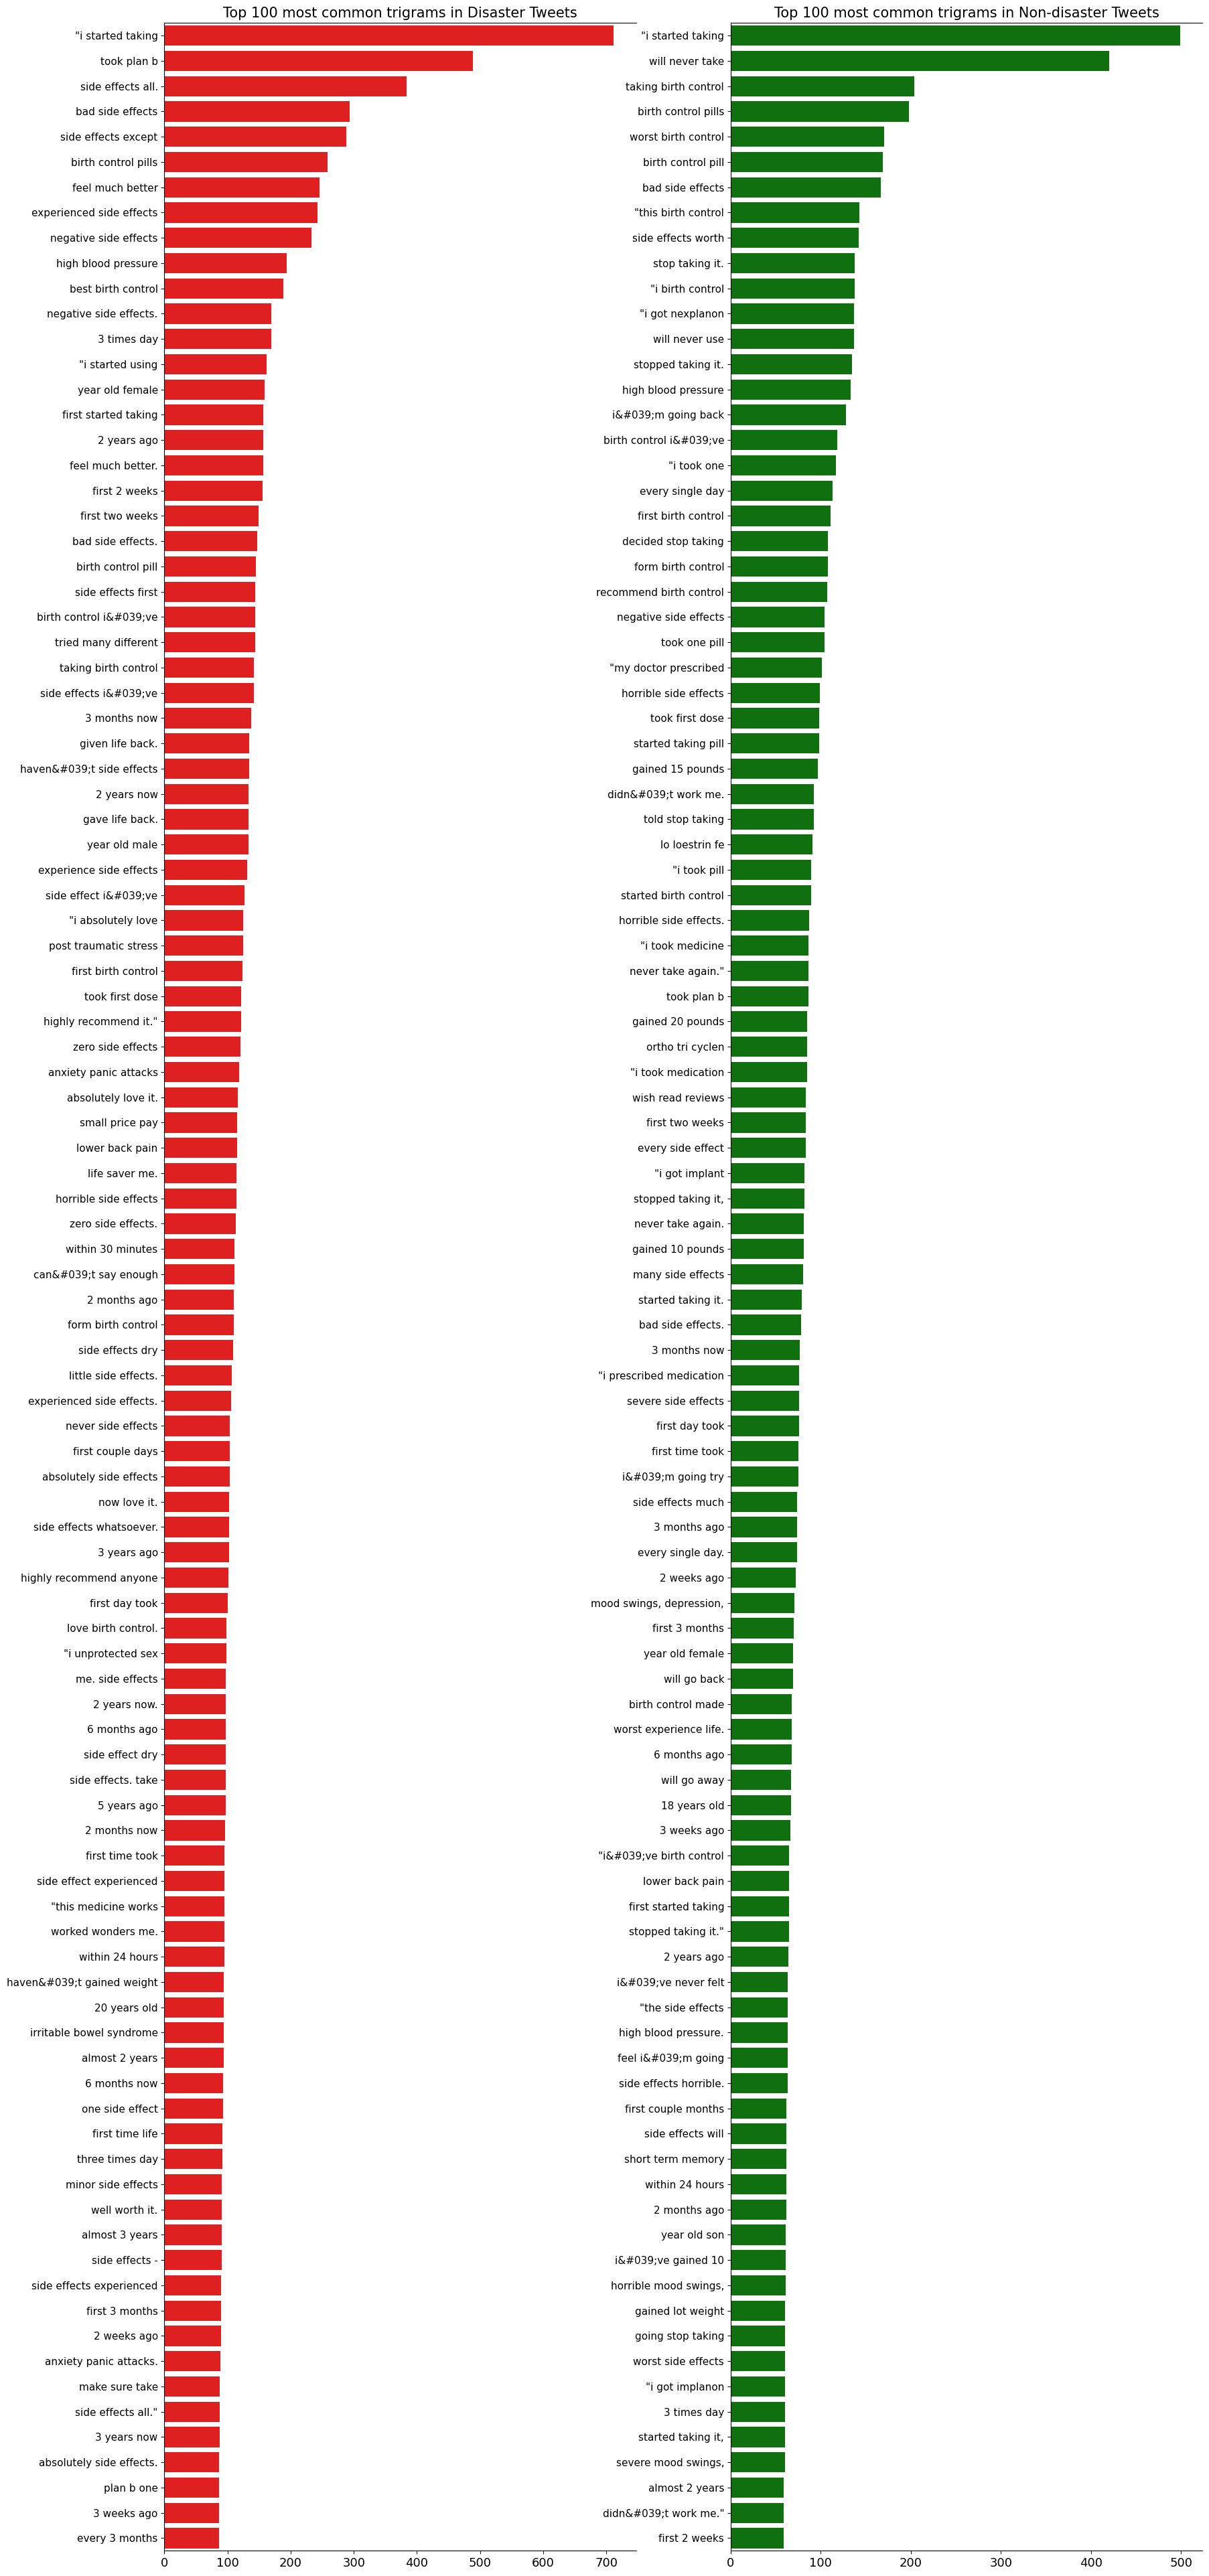

In [0]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

In [0]:
%%time
import pickle
from time import time
glove_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/glove.840B.300d.pkl', allow_pickle=True)


CPU times: user 6.9 s, sys: 5.99 s, total: 12.9 s
Wall time: 33.4 s


In [0]:
%%time
import pickle
from time import time
fasttext_embeddings = np.load('/content/drive/My Drive/WSU/Semester 2/IE 7860/Final Project/crawl-300d-2M.pkl', allow_pickle=True)


CPU times: user 6.95 s, sys: 3.54 s, total: 10.5 s
Wall time: 33.4 s


In [0]:
def build_vocab(X):
    
    reviews = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in reviews:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_main['text'], glove_embeddings)
#test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
#print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))



GloVe Embeddings cover 31.05% of vocabulary and 89.56% of text in Training Set


In [0]:
train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_main['text'], fasttext_embeddings)
#test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
#print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

FastText Embeddings cover 34.55% of vocabulary and 90.95% of text in Training Set


In [0]:
%%time

def clean(review): 
            
    # Special characters
    review = re.sub(r"\x89Û_", "", review)
    review = re.sub(r"\x89ÛÒ", "", review)
    review = re.sub(r"\x89ÛÓ", "", review)
    review = re.sub(r"\x89ÛÏWhen", "When", review)
    review = re.sub(r"\x89ÛÏ", "", review)
    review = re.sub(r"China\x89Ûªs", "China's", review)
    review = re.sub(r"let\x89Ûªs", "let's", review)
    review = re.sub(r"\x89Û÷", "", review)
    review = re.sub(r"\x89Ûª", "", review)
    review = re.sub(r"\x89Û\x9d", "", review)
    review = re.sub(r"å_", "", review)
    review = re.sub(r"\x89Û¢", "", review)
    review = re.sub(r"\x89Û¢åÊ", "", review)
    review = re.sub(r"fromåÊwounds", "from wounds", review)
    review = re.sub(r"åÊ", "", review)
    review = re.sub(r"åÈ", "", review)
    review = re.sub(r"JapÌ_n", "Japan", review)    
    review = re.sub(r"Ì©", "e", review)
    review = re.sub(r"å¨", "", review)
    review = re.sub(r"SuruÌ¤", "Suruc", review)
    review = re.sub(r"åÇ", "", review)
    review = re.sub(r"å£3million", "3 million", review)
    review = re.sub(r"åÀ", "", review)
    
    # Contractions
    review = re.sub(r"he's", "he is", review)
    review = re.sub(r"there's", "there is", review)
    review = re.sub(r"We're", "We are", review)
    review = re.sub(r"That's", "That is", review)
    review = re.sub(r"won't", "will not", review)
    review = re.sub(r"they're", "they are", review)
    review = re.sub(r"Can't", "Cannot", review)
    review = re.sub(r"wasn't", "was not", review)
    review = re.sub(r"don\x89Ûªt", "do not", review)
    review = re.sub(r"aren't", "are not", review)
    review = re.sub(r"isn't", "is not", review)
    review = re.sub(r"What's", "What is", review)
    review = re.sub(r"haven't", "have not", review)
    review = re.sub(r"hasn't", "has not", review)
    review = re.sub(r"There's", "There is", review)
    review = re.sub(r"He's", "He is", review)
    review = re.sub(r"It's", "It is", review)
    review = re.sub(r"You're", "You are", review)
    review = re.sub(r"I'M", "I am", review)
    review = re.sub(r"shouldn't", "should not", review)
    review = re.sub(r"wouldn't", "would not", review)
    review = re.sub(r"i'm", "I am", review)
    review = re.sub(r"I\x89Ûªm", "I am", review)
    review = re.sub(r"I'm", "I am", review)
    review = re.sub(r"Isn't", "is not", review)
    review = re.sub(r"Here's", "Here is", review)
    review = re.sub(r"you've", "you have", review)
    review = re.sub(r"you\x89Ûªve", "you have", review)
    review = re.sub(r"we're", "we are", review)
    review = re.sub(r"what's", "what is", review)
    review = re.sub(r"couldn't", "could not", review)
    review = re.sub(r"we've", "we have", review)
    review = re.sub(r"it\x89Ûªs", "it is", review)
    review = re.sub(r"doesn\x89Ûªt", "does not", review)
    review = re.sub(r"It\x89Ûªs", "It is", review)
    review = re.sub(r"Here\x89Ûªs", "Here is", review)
    review = re.sub(r"who's", "who is", review)
    review = re.sub(r"I\x89Ûªve", "I have", review)
    review = re.sub(r"y'all", "you all", review)
    review = re.sub(r"can\x89Ûªt", "cannot", review)
    review = re.sub(r"would've", "would have", review)
    review = re.sub(r"it'll", "it will", review)
    review = re.sub(r"we'll", "we will", review)
    review = re.sub(r"wouldn\x89Ûªt", "would not", review)
    review = re.sub(r"We've", "We have", review)
    review = re.sub(r"he'll", "he will", review)
    review = re.sub(r"Y'all", "You all", review)
    review = re.sub(r"Weren't", "Were not", review)
    review = re.sub(r"Didn't", "Did not", review)
    review = re.sub(r"they'll", "they will", review)
    review = re.sub(r"they'd", "they would", review)
    review = re.sub(r"DON'T", "DO NOT", review)
    review = re.sub(r"That\x89Ûªs", "That is", review)
    review = re.sub(r"they've", "they have", review)
    review = re.sub(r"i'd", "I would", review)
    review = re.sub(r"should've", "should have", review)
    review = re.sub(r"You\x89Ûªre", "You are", review)
    review = re.sub(r"where's", "where is", review)
    review = re.sub(r"Don\x89Ûªt", "Do not", review)
    review = re.sub(r"we'd", "we would", review)
    review = re.sub(r"i'll", "I will", review)
    review = re.sub(r"weren't", "were not", review)
    review = re.sub(r"They're", "They are", review)
    review = re.sub(r"Can\x89Ûªt", "Cannot", review)
    review = re.sub(r"you\x89Ûªll", "you will", review)
    review = re.sub(r"I\x89Ûªd", "I would", review)
    review = re.sub(r"let's", "let us", review)
    review = re.sub(r"it's", "it is", review)
    review = re.sub(r"can't", "cannot", review)
    review = re.sub(r"don't", "do not", review)
    review = re.sub(r"you're", "you are", review)
    review = re.sub(r"i've", "I have", review)
    review = re.sub(r"that's", "that is", review)
    review = re.sub(r"i'll", "I will", review)
    review = re.sub(r"doesn't", "does not", review)
    review = re.sub(r"i'd", "I would", review)
    review = re.sub(r"didn't", "did not", review)
    review = re.sub(r"ain't", "am not", review)
    review = re.sub(r"you'll", "you will", review)
    review = re.sub(r"I've", "I have", review)
    review = re.sub(r"Don't", "do not", review)
    review = re.sub(r"I'll", "I will", review)
    review = re.sub(r"I'd", "I would", review)
    review = re.sub(r"Let's", "Let us", review)
    review = re.sub(r"you'd", "You would", review)
    review = re.sub(r"It's", "It is", review)
    review = re.sub(r"Ain't", "am not", review)
    review = re.sub(r"Haven't", "Have not", review)
    review = re.sub(r"Could've", "Could have", review)
    review = re.sub(r"youve", "you have", review)  
    review = re.sub(r"donå«t", "do not", review)   
            
    # Character entity references
    review = re.sub(r"&gt;", ">", review)
    review = re.sub(r"&lt;", "<", review)
    review = re.sub(r"&amp;", "&", review)
    
    # Typos, slang and informal abbreviations
    review = re.sub(r"w/e", "whatever", review)
    review = re.sub(r"w/", "with", review)
    review = re.sub(r"USAgov", "USA government", review)
    review = re.sub(r"recentlu", "recently", review)
    review = re.sub(r"Ph0tos", "Photos", review)
    review = re.sub(r"amirite", "am I right", review)
    review = re.sub(r"exp0sed", "exposed", review)
    review = re.sub(r"<3", "love", review)
    review = re.sub(r"amageddon", "armageddon", review)
    review = re.sub(r"Trfc", "Traffic", review)
    review = re.sub(r"8/5/2015", "2015-08-05", review)
    review = re.sub(r"WindStorm", "Wind Storm", review)
    review = re.sub(r"8/6/2015", "2015-08-06", review)
    review = re.sub(r"10:38PM", "10:38 PM", review)
    review = re.sub(r"10:30pm", "10:30 PM", review)
    review = re.sub(r"16yr", "16 year", review)
    review = re.sub(r"lmao", "laughing my ass off", review)   
    review = re.sub(r"TRAUMATISED", "traumatized", review)
    
               
    # Urls
    review = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", review)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        review = review.replace(p, f' {p} ')
        
    # ... and ..
    review = review.replace('...', ' ... ')
    if '...' not in review:
        review = review.replace('..', ' ... ')      
        
    return review

df_main['text_cleaned'] = df_main['text'].apply(lambda s : clean(s))
#df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_main['text_cleaned'], glove_embeddings)
#test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
#print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_main['text_cleaned'], fasttext_embeddings)
#test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
#print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 59.32% of vocabulary and 96.24% of text in Training Set
FastText Embeddings cover 59.11% of vocabulary and 96.54% of text in Training Set
CPU times: user 26 s, sys: 69.7 ms, total: 26.1 s
Wall time: 26.2 s


In [0]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = df_main['target'] == 1
print('Whole Training Set Shape = {}'.format(df_main.shape))
#print('Whole Training Set Unique keyword Count = {}'.format(df_main['keyword'].nunique()))
print('Whole Training Set Target Rate (Positive) {}/{} (Negative)'.format(df_main[DISASTER]['target'].count(), df_main[~DISASTER]['target'].count()))


Whole Training Set Shape = (114906, 12)
Whole Training Set Target Rate (Positive) 68005/46901 (Negative)


In [0]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)


In [0]:
x = df_main['text_cleaned']
y = df_main['target']

In [0]:
from sklearn.model_selection import train_test_split
SEED = 1000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [0]:
x_train = x_train.str.lower()
x_validation = x_validation.str.lower()
x_test = x_test.str.lower()

In [0]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

In [0]:
class ReviewChecker:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        
        self.max_seq_length = max_seq_length        
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        # Learning control params
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,), dtype=tf.int32, name='segment_ids')    
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[:, 0, :]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        optimizer = SGD(learning_rate=self.lr, momentum=0.8)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        

    
        # Callbacks
        metrics = ClassificationReport(train_data=(x_train, y_train), validation_data=(x_validation, y_validation))
        
        # Model
        model = self.build_model()        
        model.fit(x_train, y_train, validation_data=(x_validation, y_validation), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
        
        self.models.append(model)
        self.scores= {
            'train': {
                'precision': metrics.train_precision_scores,
                'recall': metrics.train_recall_scores,
                'f1': metrics.train_f1_scores                    
            },
            'validation': {
                'precision': metrics.val_precision_scores,
                'recall': metrics.val_recall_scores,
                'f1': metrics.val_f1_scores                    
            }
        }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=100)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[i].history.history['val_accuracy'], ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['precision'], ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['recall'], ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.scores[i]['validation']['f1'], ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i), fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['loss'], ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1), y=clf.models[0].history.history['val_loss'], ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i), fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        y_pred = np.zeros((x_test[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(x_test) / len(self.models)

        return y_pred

In [0]:
clf = ReviewChecker(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)
clf.train(df_main)

Epoch 1/10


AssertionError: ignored

In [0]:
tf.compat.v1.get_default_graph()